In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, BatchNormalization,Activation
from tensorflow.keras.layers import LeakyReLU,Concatenate, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint
# from models.unet import *
from models.skipnet import *
from models.resnet import *
from utils.common import *
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import rescale, resize, pyramid_reduce
import os
import scipy.io as sio
import h5py
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# Load data (data are preprocessed by Matlab)
coastal_data=3
if coastal_data==1:     #Costal data
    dname="coastal"
    datapath="data/coastal.mat"
    coastal=sio.loadmat(datapath)
    X=coastal["xim"]
    scale=np.max(X)
    x=X/scale #ground truth (10 m band)
    y=coastal["yD"]/scale #input (20 m band)
    y_test=y
    xD=coastal["xU"] #interpolated 20 m bands to spatial size of 10 m band
elif coastal_data==0:                #Reykjavik
    dname="rek"
    datapath="data/reykjavik.mat"
    data = sio.loadmat(datapath)
    X=data["x20"] #ground truth
    scale=np.max(X)
    x=X/scale
    y=data["yD"]/scale #input
    y_test=y
else:
    dname="test"
    datapath="../test/current.mat"
    data = sio.loadmat(datapath)
    Xf=np.rollaxis(data["im10"][()],0,3) #ground truth
    Xc=np.rollaxis(data["im20"][()],0,3)
    XfD=resize(Xf,[round(Xf.shape[0]/2),round(Xf.shape[1]/2),Xf.shape[2]])
    XcD=resize(Xc,[round(Xc.shape[0]/2),round(Xc.shape[1]/2),Xc.shape[2]])
    XcU=resize(Xc,[Xf.shape[0],Xf.shape[1],Xc.shape[2]])
    XcDU=resize(XcD,[XfD.shape[0],XfD.shape[1],Xc.shape[2]])
    X=Xc
    y=np.concatenate([XcDU,XfD], axis=-1)
    y_test=np.concatenate([XcU,Xf], axis=-1)
    #imGT=data["imGT"][()].transpose()
    scale=np.max(X)
    x=X/scale
    y=y/scale #input
    y_test=y_test/scale
    
# We can use another downsampling technique instead of bicubic
    # yD=pyramid_reduce(y)
    # xD=rescale(pyramid_reduce(x),scale=r,order=5)
print(scale)

7293.1397696140375


In [3]:
Y=GenerateCube(y,stride=8) #input
X=GenerateCube(x,stride=8) #target
Yt=y.reshape(-1,y.shape[0],y.shape[1],y.shape[2])
Xt=x.reshape(-1,x.shape[0],x.shape[1],x.shape[2])
print(Y.shape,Xt.shape)

num_epochs = 200

skipnet=True

if skipnet:
    netname="skipnet"
    batch_size= 64
    mymodel=skip(ndown=3)
    myoptimizer=tf.keras.optimizers.Adam(learning_rate=0.0005)
    mymodel.compile(optimizer=myoptimizer, loss="mse")
else:
    netname="resnet"
    batch_size= 48
    mymodel=residualnet(K=16)
    myoptimizer=tf.keras.optimizers.Adam(learning_rate=0.0004)
    mymodel.compile(optimizer=myoptimizer, loss="mse")
# mymodel.summary()
modelpath=netname+"bestmodel.hdf5"
checkpoint = ModelCheckpoint(modelpath, monitor='val_loss', verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

h=mymodel.fit(x=Y,y=X,batch_size=batch_size,epochs=num_epochs,validation_data=(Yt,Xt),callbacks=callbacks_list)
bestmodel=tf.keras.models.load_model(modelpath)

Ypr=bestmodel.predict(y_test.reshape(-1,y_test.shape[0],y_test.shape[1],y_test.shape[2]))
Ypr=Ypr*scale

(576, 16, 16, 10) (1, 204, 204, 6)
Train on 576 samples, validate on 1 samples
Epoch 1/200
320/576 [===============>..............] - ETA: 1s - loss: 0.0571 
Epoch 00001: val_loss improved from inf to 0.02269, saving model to skipnetbestmodel.hdf5
576/576 [==============================] - 2s 3ms/sample - loss: 0.0417 - val_loss: 0.0227
Epoch 2/200
384/576 [===================>..........] - ETA: 0s - loss: 0.0131
Epoch 00002: val_loss improved from 0.02269 to 0.00294, saving model to skipnetbestmodel.hdf5
576/576 [==============================] - 0s 303us/sample - loss: 0.0113 - val_loss: 0.0029
Epoch 3/200
384/576 [===================>..........] - ETA: 0s - loss: 0.0042
Epoch 00003: val_loss improved from 0.00294 to 0.00198, saving model to skipnetbestmodel.hdf5
576/576 [==============================] - 0s 306us/sample - loss: 0.0038 - val_loss: 0.0020
Epoch 4/200
384/576 [===================>..........] - ETA: 0s - loss: 0.0022
Epoch 00004: val_loss improved from 0.00198 to 0.0012

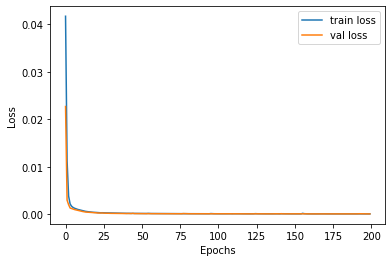

In [4]:
fig1=plt.figure()
plt.plot(range(num_epochs),h.history["loss"],label="train loss")
plt.plot(range(num_epochs),h.history["val_loss"],label="val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
# fig1.savefig("skipnetloss_rek.png")

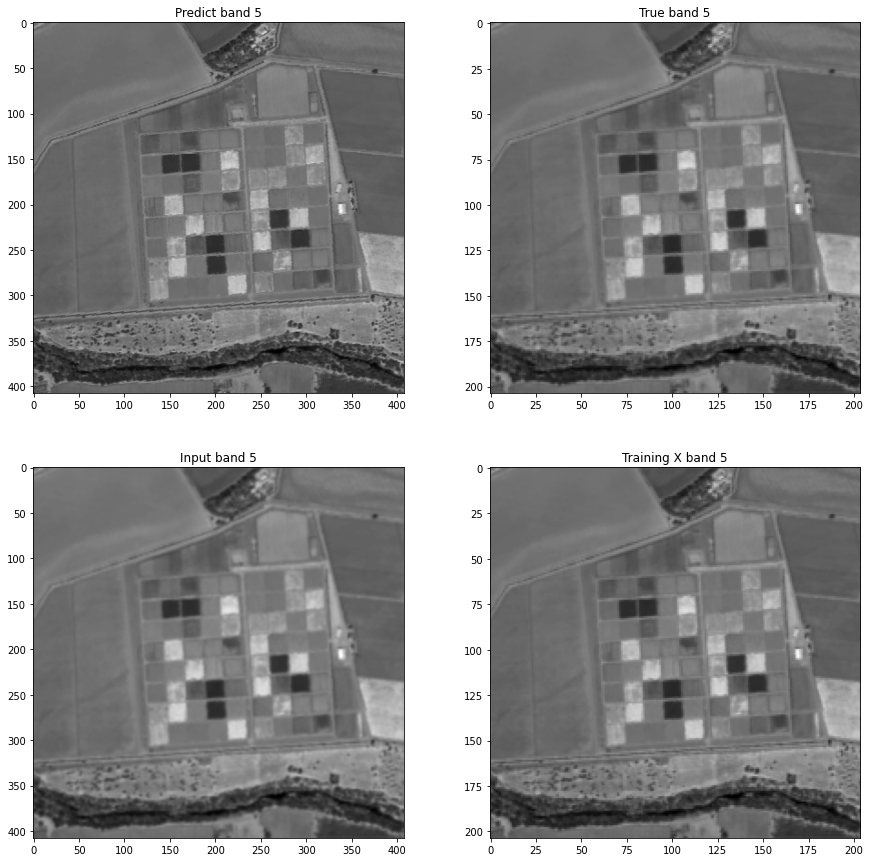

In [5]:
# msre,sre=sreCal(x*scale,Ypr[0])
# bmsre,bsre=sreCal(x,xD)
# print("Each band",sre)
# print("Mean SRE: ",msre)
# print("Each band bicubic",bsre)
# print("Mean SRE bicubic: ",bmsre)
plt.figure(figsize=(15,15))
band=0
plt.subplot(221)
plt.imshow(Ypr[0][:,:,0],cmap="gray")
plt.title("Predict band 5")
plt.subplot(222)
plt.imshow(x[:,:,0]/scale,cmap="gray")
plt.title("True band 5")
plt.subplot(223)
plt.imshow(y_test[:,:,0],cmap="gray")
plt.title("Input band 5")
plt.subplot(224)
plt.imshow(x[:,:,0],cmap="gray")
plt.title("Training X band 5")
# plt.subplot(133)
# plt.imshow(xD[:,:,showband],cmap="gray")
# plt.title("Bicubic band 5")
plt.show()

In [6]:
Yp = np.double(Ypr[0])

In [9]:
sio.savemat('../test/results/han_aviris.mat',{'Ypr': Yp, 'tHan': np.double(35.5)} 'stdHan': np.double(35.5)})

In [8]:
Yp.shape

(408, 408, 6)